# Setup package dependencies

In [1]:

import os

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "1"


import numpy as np 
np.set_printoptions(precision=3)
import random

import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams["axes.xmargin"] = 0
plt.rcParams["toolbar"] = "None"
plt.rcParams["axes.titlesize"] = 10

from IPython.display import display

import tensorflow as tf
import tensorflow.keras as tfk

from pathlib import Path
import librosa

from sklearn.utils import shuffle
from utils import get_spectrogram, plot_spectrogram, plot_eval

#### Assure repeatability


In [2]:
import os

random_seed = 42
os.environ["PYTHONHASHSEED"] = "42"
np.random.seed(random_seed)
random.seed(random_seed)
tfk.utils.set_random_seed(random_seed)

# Get data

In [3]:
labels = []
data_dir = Path("DATA")
for subdir in data_dir.iterdir():
    if subdir.is_dir():
        labels.append(subdir.name)
label_names = labels
print(f"Labels: {labels}")

Labels: ['GUNS', 'ENV']


# E.D.A


#### Get some audio examples of each class


In [4]:
ex_data = []
ex_label = []
Nex = 10
for item in data_dir.glob("ENV/*.wav"):
    sr_in0 = librosa.get_samplerate(str(item))
    data, sr_in = librosa.load(str(item), sr=sr_in0, mono=True)
    data = librosa.resample(data, orig_sr=sr_in, target_sr=16000)
    ex_data.append(data)
    ex_label.append("ENV")
    if len(ex_data) == Nex:
        break
for item in data_dir.glob("GUNS/*.wav"):
    data, sr_in = librosa.load(str(item), mono=True)
    data = librosa.resample(data, orig_sr=sr_in, target_sr=16000)
    ex_data.append(data)
    ex_label.append("GUNS")
    if len(ex_data) == Nex:
        break

In [5]:
from IPython.display import Audio

print("Label:", ex_label[0])
print("Waveform shape:", ex_data[0].shape)
print("Audio playback")
Audio(ex_data[0], rate=16000)

Label: ENV
Waveform shape: (4096,)
Audio playback


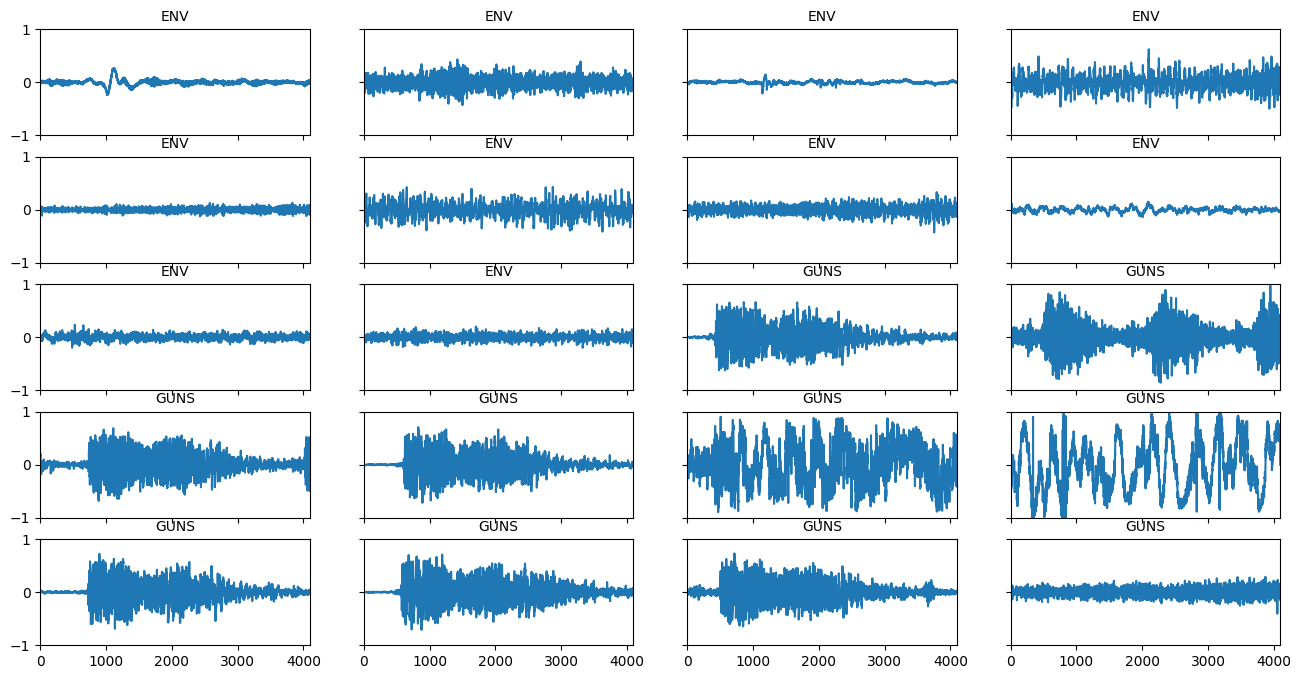

In [6]:
rows = 5
cols = 4
fig, ax = plt.subplots(
    nrows=rows, ncols=cols, figsize=(16, 8), sharex="all", sharey="all"
)
n = rows * cols
for i in range(n):
    ix = i
    plt.subplot(rows, cols, i + 1)
    plt.plot(ex_data[ix])
    plt.title(ex_label[ix])
    plt.ylim([-1, 1])

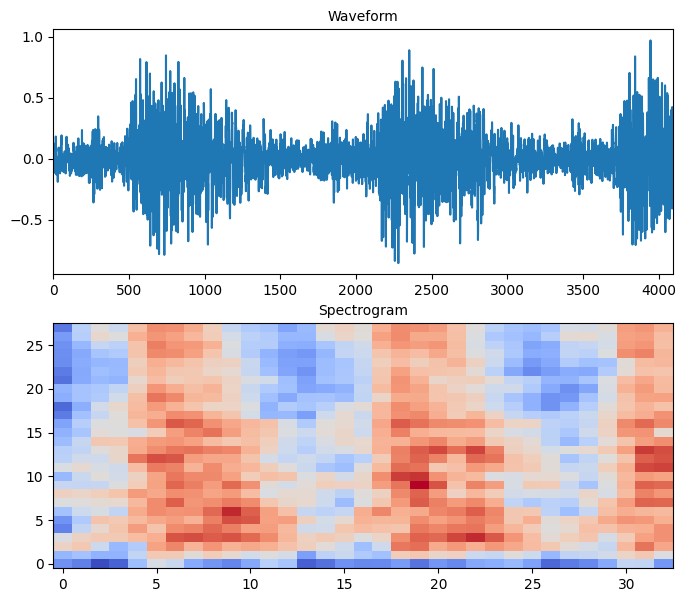

In [7]:
fig, ax = plt.subplots(2, figsize=(8, 7))
ax[0].plot(ex_data[11])
ax[0].set_title("Waveform")
Smel = get_spectrogram(ex_data[11])
plot_spectrogram(Smel, ax[1])
ax[1].set_title("Spectrogram")
plt.show()

In [8]:
Imean = np.mean(Smel)
Imax = np.max(Smel)
Imin = np.min(Smel)
Istd = np.std(Smel)
print(f"Max:  {Imax} \nMin:  {Imin} \nMean: {Imean} \nStd:  {Istd}")

Max:  -15.925579589050823 
Min:  -46.228035326230916 
Mean: -29.47740903483419 
Std:  5.930408710525887


## Generate dataset


In [9]:
# Feature extraction - Mel spectrogram:
def get_feature_mel(fname):
    sr_in0 = librosa.get_samplerate(fname)
    data, sr_in = librosa.load(fname, sr=sr_in0, mono=True)
    data = librosa.resample(data, orig_sr=sr_in, target_sr=16000)
    S = get_spectrogram(data)
    # print(f"{np.max(S)}")
    return S


def augment_mel(X, y):
    X_out = []
    y_out = []
    for i in range(X.shape[0]):
        # Augment probability
        if np.random.randint(100) < 30:
            x = X[i].copy()
            r, c = x.shape
            # Randomly select a section of the mel spectrogram to be attenuated [in dB]
            match np.random.randint(0, 12):
                case 0 | 1 | 2 | 3 :  # White noise
                    # White noise
                    x = np.multiply(
                        x, np.random.uniform(low=0.85, high=0.99, size=x.shape)
                    )
                case  5 | 6 | 7 | 8:  #  HP filter
                    x[0, :] -= 6
                    x[1, :] -= 3 
                case 8 | 9 | 10 | 11:  # LP filter
                    x[r - 1, :] -= 6
                    x[r - 2, :] -= 3

            X_out.append(x)
            y_out.append(y[i])
    return np.array(X_out), np.array(y_out)

In [10]:
X = []
y = []

for item in data_dir.glob("*/*.wav"):
    # One hot encoding based on label name from dir structure
    t = np.zeros(len(labels), dtype=int)
    t[labels.index(item.parts[-2])] = 1

    # Get feature
    feat = get_feature_mel(str(item))
    X.append(feat)
    y.append(t)

X = np.array(X)
y = np.array(y)

# Shuffle data
X, y = shuffle(X, y)

# Split: 80 -10 - 10%
Ntot = X.shape[0]
Ntrain = int(0.8 * Ntot)
Ntest = int(0.1 * Ntot)
Nval = Ntot - Ntrain - Ntest

X_train = X[:Ntrain]
y_train = y[:Ntrain]

X_val = X[Ntrain : Ntot - Ntest]
y_val = y[Ntrain : Ntot - Ntest]

X_test = X[Ntot - Ntest :]
y_test = y[Ntot - Ntest :]

print(f"Total samples: {y.shape[0]}")
print(f"Train samples: {y_train.shape[0]}")
print(f"Val samples: {y_val.shape[0]}")
print(f"Test samples: {y_test.shape[0]}")

# Convert to Dataset
val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val))
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))

Total samples: 7622
Train samples: 6097
Val samples: 763
Test samples: 762


In [11]:
# Augment training data
X_aug, y_aug = augment_mel(X_train, y_train)

X_train = np.concatenate((X_aug, X_train), axis=0)
y_train = np.concatenate((y_aug, y_train), axis=0)

print(f"Adding augmented samples:  {y_aug.shape[0]}")
print(f"New total traning samples: {y_train.shape[0]}")

X_train, y_train = shuffle(X_train, y_train)

# Convert to Dataset
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))

Adding augmented samples:  1856
New total traning samples: 7953


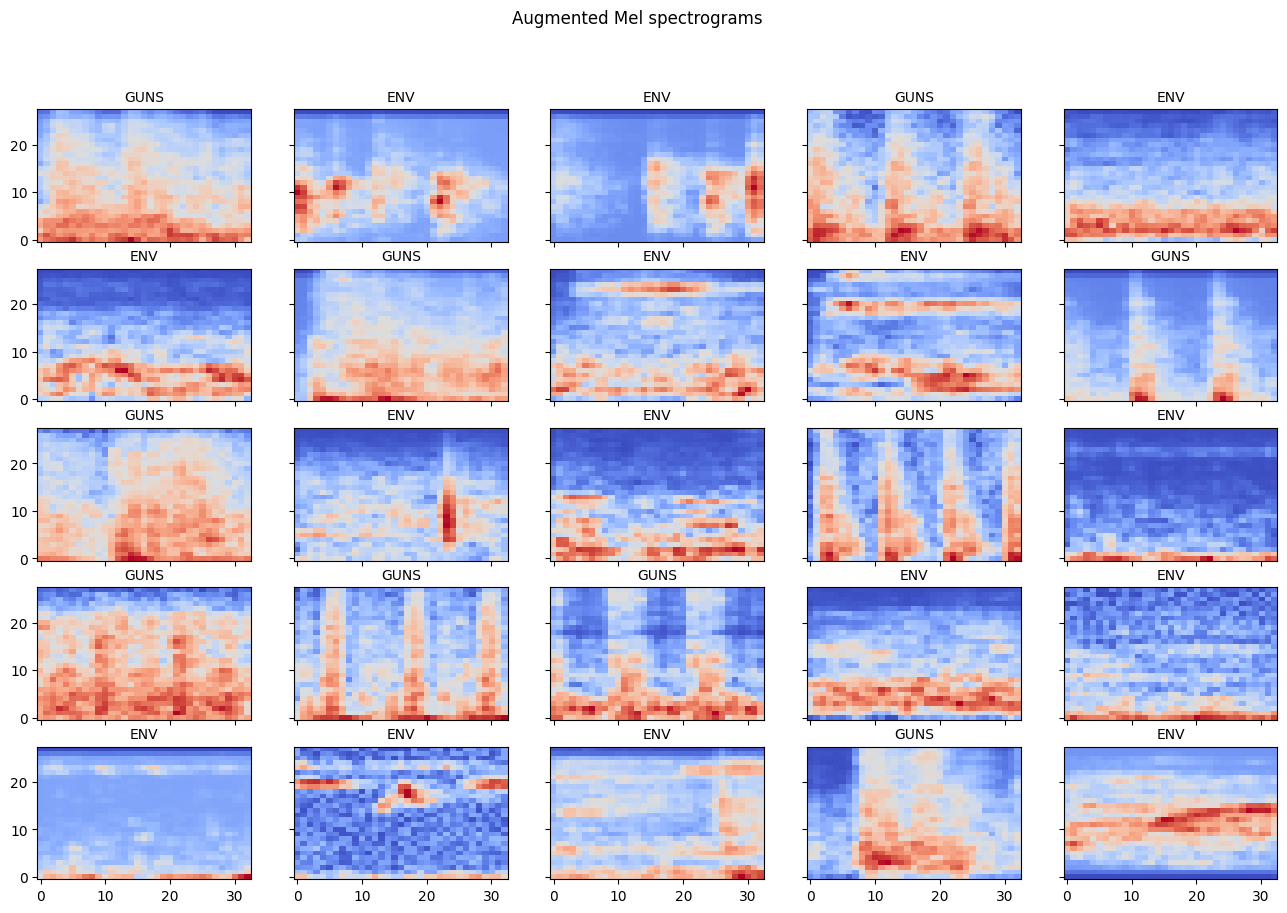

In [12]:
rows = 5
cols = 5
i = 0
fig, axes = plt.subplots(rows, cols, figsize=(16, 10), sharex="all", sharey="all")

aa = zip(X_aug[:25],y_aug[:25])
for xx,yy in aa:
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    i = i + 1
    plot_spectrogram(xx,ax)
    ax.set_title(label_names[np.argmax(yy)])
plt.suptitle("Augmented Mel spectrograms")
plt.show()

In [13]:
train_ds = train_ds.cache().shuffle(35000).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.cache().prefetch(tf.data.AUTOTUNE)


def exp_ds_dim(data, label):
    data = data[..., tf.newaxis]
    return data, label

train_ds = train_ds.map(exp_ds_dim).batch(32)
val_ds = val_ds.map(exp_ds_dim).batch(32)
test_ds = test_ds.map(exp_ds_dim).batch(32)


In [17]:
input_shape = (28, 28, 1)
print("Input shape:", input_shape)
num_labels = len(label_names)

model = tfk.models.Sequential(
    [
        tfk.layers.Input(shape=input_shape),
        tfk.layers.Conv2D(64, 3, activation="relu", padding="valid"),
        tfk.layers.Dropout(0.2),
        tfk.layers.MaxPooling2D(),
        tfk.layers.Conv2D(128, 3, activation="relu", padding="valid"),
        tfk.layers.MaxPooling2D(),
        tfk.layers.Conv2D(128, 3, activation="relu", padding="valid"),
        # tfk.layers.Dropout(0.1),
        tfk.layers.MaxPooling2D(),
        tfk.layers.Conv2D(256, (1, 1), activation="relu"),
        tfk.layers.Conv2D(128, (1, 1), activation="relu"),
        tfk.layers.Conv2D(num_labels, (1, 1), activation="sigmoid"),
        tfk.layers.GlobalMaxPooling2D(),
    ]
)
model.summary()

Input shape: (28, 28, 1)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 26, 26, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 26, 26, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 13, 13, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 11, 11, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 5, 5, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 3, 3, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 1, 1, 256)      │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 1, 1, 128)      │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 1, 1, 2)        │           258 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling2d_1          │ (None, 2)              │             0 │
│ (GlobalMaxPooling2D)            │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 288,258 (1.10 MB)

 Trainable params: 288,258 (1.10 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
def lr_schedule(epoch):
    if epoch > 25:
        return 0.00003
    if epoch > 10:
        return 0.0001
    elif epoch > 5:
        return 0.0003
    else:
        return 0.00001  # Warmup


learnRate_cb = tfk.callbacks.LearningRateScheduler(lr_schedule)

# Early stop callback
earlyStop_cb = tfk.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=7,
    verbose=1,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
)

callbacks = [learnRate_cb, earlyStop_cb]

Epoch 1/50
249/249 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - accuracy: 0.5660 - loss: 0.6609 - val_accuracy: 0.8152 - val_loss: 0.6199 - learning_rate: 1.0000e-05
Epoch 2/50
249/249 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - accuracy: 0.8067 - loss: 0.5895 - val_accuracy: 0.8794 - val_loss: 0.5452 - learning_rate: 1.0000e-05
Epoch 3/50
249/249 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.8688 - loss: 0.5153 - val_accuracy: 0.8873 - val_loss: 0.4832 - learning_rate: 1.0000e-05
Epoch 4/50
249/249 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.9239 - loss: 0.4524 - val_accuracy: 0.8847 - val_loss: 0.4511 - learning_rate: 1.0000e-05
Epoch 5/50
249/249 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - accuracy: 0.9246 - loss: 0.4249 - val_accuracy: 0.9384 - val_loss: 0.4152 - learning_rate: 1.0000e-05
Epoch 6/50
249/249 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.9466 - loss: 0.4006 - val_accuracy: 0.9463 - val_loss: 0.3960 - learning_rate: 1.0000e-05
Epoch 7/50
249/249 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - acc

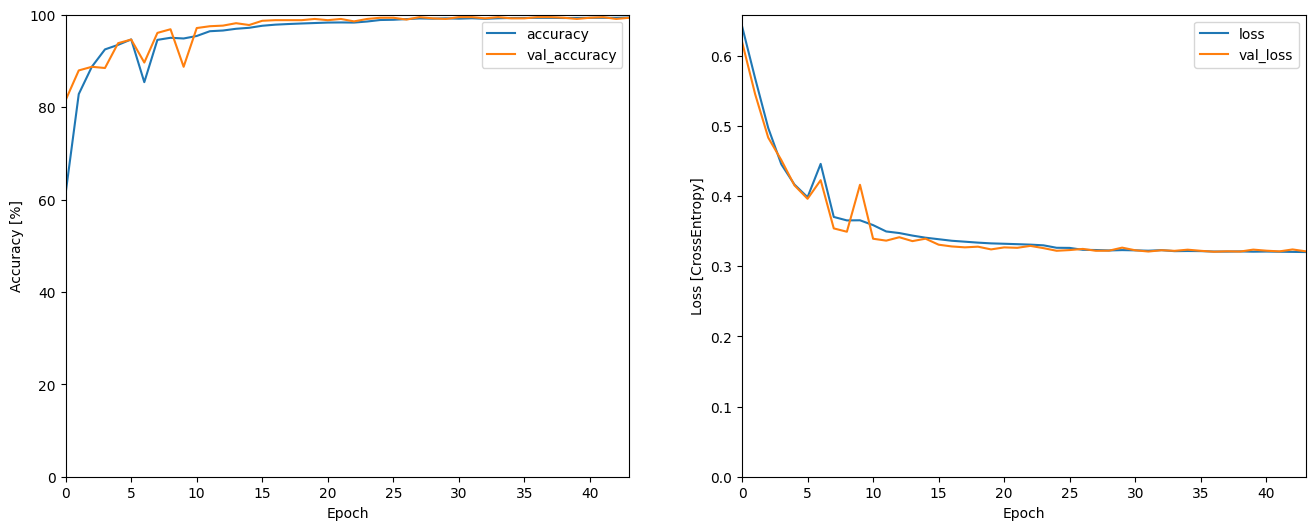

In [19]:
EPOCHS = 50
model.compile(
    optimizer=tfk.optimizers.Adam(),
    loss=tfk.losses.CategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callbacks,
)

plot_eval(history)

a = model.evaluate(test_ds, return_dict=True)
print(f"Accuracy: {100*a['accuracy']:0.2f}% \U0001f44d \nLoss:     {a['loss']:0.4f}")

In [20]:
# Save model
import pickle

with open("GunSound_FCN.pkl", "wb") as f:
    pickle.dump(model, f)